In [1]:
import csv
import requests
import os
import pandas as pd
from urllib.parse import urlparse

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties

import datetime

import xml.etree.ElementTree as ET


import geopandas as gpd
import mapclassify

from geopandas.tools import sjoin
from shapely.geometry import Point
from geopandas import datasets, GeoDataFrame, read_file
from geopandas.tools import overlay

myfont = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc')
#myfont = FontProperties(fname=r'C:\Windows\Fonts\NotoSansCJKtc-Regular.otf')

# 建立函數

In [2]:
#取得即時資料庫 M06A路徑原始資料
#儲存在該日期的資料夾中
#日期格式 20210611

def downloadFromWeb_M06A(day):
    #產生url的list
    paths_list = []

    for i in range(24):
        hour = str(i).zfill(2)

        path = 'https://tisvcloud.freeway.gov.tw/history/TDCS/M06A/' +  \
                day +'/' + hour + '/TDCS_M06A_' + day + '_' + hour + '0000.csv'
        print(path)
        paths_list.append(path)
    
    os.makedirs('M06A/' +day, exist_ok=True) 
    #os.mkdir(day)
        
    #開始下載
    for path in paths_list:
        a = urlparse(path)
        filename = os.path.basename(a.path)

        req = requests.get(path)
        url_content = req.content
        csv_file = open('M06A/' + day +'/' + filename, 'wb')

        csv_file.write(url_content)
        csv_file.close()


In [3]:
#將該資料夾內的csv  M06A  檔都轉換成df
#儲存在該日期的資料夾中
#日期格式 20210611
#事先解壓縮放到以日期為名的資料夾中

# VehicleType：	車種，31小客車、32小貨車、41大客車、42大貨車、5聯結車
# DetectionTime_O：	車輛通過本旅次第1個測站時間
# GantryID_O：	車輛通過本旅次第1個測站編號
# DetectionTime_D：	車輛通過本旅次最後1個測站時間
# GantryID_D：	車輛通過本旅次最後1個測站編號
# TripLength：	本旅次行駛距離
# TripEnd：	旅次標記(Y正常結束，N異常)
# TripInformation：	本旅次經過各個測站之通過時間及編號

def csvToDf_M06A( folderName ):
    filenames_list = []
    for path, subdirs, files in os.walk( folderName ):
        for name in files:
            #print(os.path.join(path, name))
            filename = os.path.join(path, name)
            filenames_list.append(filename)    

            
    #讀取資料
    travel_distance = []
    for filename in filenames_list:
        with open(filename, newline='') as f:
            reader = csv.reader(f)
            data = list(reader)
            for d in data :
                travel_distance.append(d)
    #list 轉 df
    columns_name = ['VehicleType','DetectionTime_O','GantryID_O','DetectionTime_D',
                    'GantryID_D','TripLength','TripEnd','TripInformation']
    df = pd.DataFrame (travel_distance,columns = columns_name )
    return df


# 使用 各旅次路徑原始資料繪圖

## 讀取 etags站資料

### 讀取E-tag xml
####  https://tisvcloud.freeway.gov.tw/history/motc20/ETag.xml

1. UpdateTime：	本平台資料更新時間(ISO8601格式:yyyy-MM-ddTHH:mm:sszzzz)
2. UpdateInterval：	本平台資料更新週期(秒)
3. AuthorityCode：	業管機關簡碼
4. ETagGantryID：	eTag偵測站代碼
5. LinkID：	基礎路段代碼, 請參閱[基礎路段代碼表]https://traffic-api-documentation.gitbook.io/traffic/xiang-dai-zhao-biao
6. LocationType：	設置地點位置類型 = ['1: 路側', '2: 道路中央分隔島', '3: 快慢分隔島', '4: 車道上門架', '5: 車道鋪面', '6: 其他']
7. PositionLon：	設備架設位置 X 坐標
8. PositionLat：	設備架設位置 Y 坐標
9. RoadID：	道路代碼, 請參閱[路名碼基本資料]https://traffic-api-documentation.gitbook.io/traffic/xiang-dai-zhao-biao
10. RoadName：	道路名稱
11. RoadClass：	道路分類 = ['0: 國道', '1: 快速道路', '2: 市區快速道路', '3: 省道', '4: 縣道', '5: 鄉道', '6: 市區一般道路', '7: 匝道']
12. RoadDirection：	基礎路段所屬道路方向, 請參閱[道路方向資料表]https://traffic-api-documentation.gitbook.io/traffic/xiang-dai-zhao-biao
13. Start：	路段起點描述
14. End：	路段迄點描述
15. LocationMile：	所在方向里程數

In [4]:
# 讀取etags xml，存入df_etags 。用來解析龍門架的位置

#從檔案載入並解析 XML 資料
tree = ET.parse('eTag 靜態資訊/ETag.xml')
root = tree.getroot()

etags_list = []
for idx , child in enumerate(root[3]):
    print(idx)
    etag = []
    for idx_2, child_2 in enumerate(child) :
        #print(child_2.tag)
        #print(child_2.attrib)
        if idx_2 == 9:
            for child_3 in child_2:
                print(child_3.text)
                etag.append(child_3.text)
        else:
            print(child_2.text)
            etag.append(child_2.text)
    etags_list.append(etag)
    print('****')
    
#存入df_etags
etag_columns = ['ETagGantryID','LinkID','LocationType','PositionLon','PositionLat',
               'RoadID','RoadName','RoadClass','RoadDirection','Start','End','LocationMile',]

df_etags = pd.DataFrame (etags_list,columns = etag_columns )  

0
03F2899N
0000300129000Q
4
120.48633
23.511683
000030
國道3號
0
N
竹崎(159縣道)
竹崎(竹崎連絡道)
289K+900
****
1
05F0000S
0000501001000A
4
121.62302
25.035183
000050
國道5號
0
S
南港系統(連接國3)
石碇
0K+000
****
2
03F2306N
0000300123000M
4
120.70283
23.90678
000030
國道3號
0
N
南投服務區
南投
230K+600
****
3
01F3227N
0000100132300D
4
120.25
23.014172
000010
國道1號
0
N
大灣
永康
322K+700
****
4
03F1991S
0000300019900N
4
120.57766
24.102808
000030
國道3號
0
S
彰化系統(連接國1)
快官(連接台74)
199K+100
****
5
03F2415N
0000300124100M
4
120.700005
23.814837
000030
國道3號
0
N
竹山
名間
241K+500
****
6
03F2306S
0000300023000M
4
120.70283
23.90678
000030
國道3號
0
S
南投
南投服務區
230K+600
****
7
03F2415S
0000300024100M
4
120.700005
23.814837
000030
國道3號
0
S
名間
竹山
241K+500
****
8
01F3227S
0000100032300D
4
120.25
23.014172
000010
國道1號
0
S
永康
大灣
322K+700
****
9
03F0846N
0000300108400J
4
121.126
24.79144
000030
國道3號
0
N
竹林
關西
84K+600
****
10
03F0006S
0000300000070C
4
121.70891
25.137106
000030
國道3號
0
S
基金
瑪東系統(連接台62)
0K+600
****
11
03F0846S
0000300008400J
4
121.126


24.262648
000010
國道1號
0
N
豐原
台中系統(連接國4)
166K+400
****
213
03F2235S
0000300022340M
4
120.66127
23.955503
000030
國道3號
0
S
中興系統(台76-八卦山隧道)
中興
223K+500
****
214
03F2194N
0000300121900M
4
120.65272
23.985844
000030
國道3號
0
N
中興系統(台76-八卦山隧道)
草屯
219K+400
****
215
01F3083N
0000100130800D
4
120.23327
23.14075
000010
國道1號
0
N
安定
麻豆
308K+300
****
216
01F3083S
0000100030800D
4
120.23327
23.14075
000010
國道1號
0
S
麻豆
安定
308K+300
****
217
01F0376S
0000100003700F
4
121.39731
25.058666
000010
國道1號
0
S
高公局
林口(文化一路)
37K+600
****
218
01F1839N
0000100118300B
4
120.61725
24.130768
000010
國道1號
0
N
王田
南屯
183K+900
****
219
01F0950S
0000100009470O
4
121.00525
24.789621
000010
國道1號
0
S
新竹(光復路)
新竹(科學園區)
95K+000
****
220
03F1779N
0000300117700B
4
120.59331
24.234648
000030
國道3號
0
N
龍井
沙鹿
177K+900
****
221
03F2194S
0000300021900M
4
120.65272
23.985844
000030
國道3號
0
S
草屯
中興系統(台76-八卦山隧道)
219K+400
****
222
03F3445N
0000300134400D
4
120.32903
23.085272
000030
國道3號
0
N
新化系統(連接國8)
善化
344K+500
****
223
03F1779S
000030001770

## 檢查etags位在哪個縣市

In [6]:
#載入各縣市shp file
shpFile = '直轄市、縣市界線(TWD97經緯度)/COUNTY_MOI_1090820.shp'
gdf = gpd.read_file(shpFile)


<AxesSubplot:>

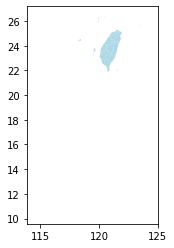

In [7]:
gdf.plot(color='lightblue')

In [8]:
#把座標轉換成 float
df_etags["PositionLon"] = pd.to_numeric(df_etags["PositionLon"], downcast="float")
df_etags["PositionLat"] = pd.to_numeric(df_etags["PositionLat"], downcast="float")


In [41]:
for x, y in zip( df_etags['PositionLon'] , df_etags['PositionLat']) :
                 print(x,y)

120.486328125 23.511682510375977
121.62301635742188 25.03518295288086
120.70282745361328 23.906780242919922
120.25 23.014171600341797
120.5776596069336 24.102807998657227
120.70000457763672 23.814836502075195
120.70282745361328 23.906780242919922
120.70000457763672 23.814836502075195
120.25 23.014171600341797
121.1259994506836 24.791439056396484
121.70890808105469 25.13710594177246
121.1259994506836 24.791439056396484
120.486328125 23.511682510375977
121.26619720458984 25.012943267822266
120.99886322021484 24.763586044311523
120.56813049316406 24.113571166992188
121.11173248291016 24.893436431884766
121.11173248291016 24.893436431884766
121.26619720458984 25.012943267822266
121.55501556396484 25.072261810302734
121.64347076416016 25.065610885620117
120.57295227050781 23.649141311645508
121.5860366821289 25.003864288330078
120.62590026855469 23.77558135986328
120.53250885009766 23.606792449951172
121.5577392578125 25.072750091552734
120.33662414550781 22.619115829467773
121.595977783203

In [9]:
etags_pointdf = GeoDataFrame([
    {'geometry': Point(x, y), 'ETagGantryID': etagId  }
    for x, y, etagId in zip( df_etags['PositionLon'] , df_etags['PositionLat'], df_etags['ETagGantryID'] ) ])


In [10]:
etags_pointdf.iloc[2]

geometry        POINT (120.7028274536133 23.90678024291992)
ETagGantryID                                       03F2306N
Name: 2, dtype: object

In [13]:
# Make sure they're using the same projection reference
etags_pointdf.crs = gdf.crs

In [19]:
#將etags龍門架對應的縣市找出來
etags_with_city_df = sjoin(etags_pointdf, gdf, how="left")

In [20]:
etags_with_city_df

,geometry,ETagGantryID,index_right,COUNTYID,COUNTYCODE,COUNTYNAME,COUNTYENG
0,POINT (120.48633 23.51168),03F2899N,13,Q,10010,嘉義縣,Chiayi County
1,POINT (121.62302 25.03518),05F0000S,6,A,63000,臺北市,Taipei City
2,POINT (120.70283 23.90678),03F2306N,3,M,10008,南投縣,Nantou County
3,POINT (120.25000 23.01417),01F3227N,9,D,67000,臺南市,Tainan City
4,POINT (120.57766 24.10281),03F1991S,2,N,10007,彰化縣,Changhua County
...,...,...,...,...,...,...,...
330,POINT (120.32219 23.34747),01F2827S,9,D,67000,臺南市,Tainan City
331,POINT (120.47491 23.70260),01F2394N,4,P,10009,雲林縣,Yunlin County
332,POINT (120.76442 24.57964),03F1332N,11,K,10005,苗栗縣,Miaoli County
333,POINT (121.78946 24.71068),05F0439S,1,G,10002,宜蘭縣,Yilan County


In [29]:
def etagInWhichCity( gantryId):
    for idx, etag in etags_with_city_df.iterrows():
        if gantryId == etag['ETagGantryID']:
            return etag['COUNTYNAME']
            break
            
    


In [31]:
test = etagInWhichCity('03F2899N')
print(test)

嘉義縣


In [60]:
cityName_list = list(gdf['COUNTYNAME'])

In [105]:
cityName_eng_list = list(gdf['COUNTYENG'])

In [61]:
cityName_list

['連江縣',
 '宜蘭縣',
 '彰化縣',
 '南投縣',
 '雲林縣',
 '基隆市',
 '臺北市',
 '新北市',
 '臺中市',
 '臺南市',
 '桃園市',
 '苗栗縣',
 '嘉義市',
 '嘉義縣',
 '金門縣',
 '高雄市',
 '臺東縣',
 '花蓮縣',
 '澎湖縣',
 '新竹市',
 '新竹縣',
 '屏東縣']

In [62]:
idex = cityName_list.index('新北市')
print(idex)

7


In [94]:
## 計算出入縣市的矩陣
def countIOcarNum(carIn, carOut):
    if carIn != None:
        i = cityName_list.index(carIn)
    if carOut!= None:
        j = cityName_list.index(carOut)
    if carIn!= None  and  carOut!= None:
        trip_array[i][j] += 1

## 下載原始路徑資料與讀取
### https://tisvcloud.freeway.gov.tw/history/TDCS/M06A/20210613/23/TDCS_M06A_20210613_230000.csv

1. VehicleType：	車種，31小客車、32小貨車、41大客車、42大貨車、5聯結車
2. DetectionTime_O：	車輛通過本旅次第1個測站時間
3. GantryID_O：	車輛通過本旅次第1個測站編號
4. DetectionTime_D：	車輛通過本旅次最後1個測站時間
5. GantryID_D：	車輛通過本旅次最後1個測站編號
6. TripLength：	本旅次行駛距離
7. TripEnd：	旅次標記(Y正常結束，N異常)
8. TripInformation：	本旅次經過各個測站之通過時間及編號

In [ ]:
# 下載資料
day = '20210611'
downloadFromWeb_M06A(day)

In [83]:
df = csvToDf_M06A('temp')
print(df)

      VehicleType      DetectionTime_O GantryID_O      DetectionTime_D  \
0              31  2021-06-11 00:14:06   03F0158S  2021-06-11 00:14:06   
1              32  2021-06-11 00:02:30   01F2156S  2021-06-11 00:02:30   
2              31  2021-06-11 00:10:45   01F2322S  2021-06-11 00:10:45   
3              31  2021-06-11 00:15:43   01F2425S  2021-06-11 00:15:43   
4              31  2021-06-11 00:29:51   01F2714S  2021-06-11 00:35:47   
...           ...                  ...        ...                  ...   
23078          31  2021-06-11 00:34:13   03F0961N  2021-06-11 00:34:13   
23079          31  2021-06-11 00:14:56   01F0233N  2021-06-11 00:14:56   
23080          31  2021-06-11 00:02:45   03F0447N  2021-06-11 00:06:42   
23081          31  2021-06-11 00:07:11   01F2011N  2021-06-11 00:17:26   
23082          31  2021-06-11 00:49:23   01H0206S  2021-06-11 01:06:47   

      GantryID_D TripLength TripEnd  \
0       03F0158S      1.200       Y   
1       01F2156S      9.100      

In [84]:
#把門架經緯度轉換成縣市
#df['city_start'] = etagInWhichCity(df['GantryID_O'])
#df['city_end'] = etagInWhichCity(df['GantryID_D'])
df['city_start'] = ''
df['city_end'] = ''
for idx,car in df.iterrows():
    
    car['city_start'] = etagInWhichCity(car['GantryID_O'])
    car['city_end'] = etagInWhichCity(car['GantryID_D'])

print(df)

      VehicleType      DetectionTime_O GantryID_O      DetectionTime_D  \
0              31  2021-06-11 00:14:06   03F0158S  2021-06-11 00:14:06   
1              32  2021-06-11 00:02:30   01F2156S  2021-06-11 00:02:30   
2              31  2021-06-11 00:10:45   01F2322S  2021-06-11 00:10:45   
3              31  2021-06-11 00:15:43   01F2425S  2021-06-11 00:15:43   
4              31  2021-06-11 00:29:51   01F2714S  2021-06-11 00:35:47   
...           ...                  ...        ...                  ...   
23078          31  2021-06-11 00:34:13   03F0961N  2021-06-11 00:34:13   
23079          31  2021-06-11 00:14:56   01F0233N  2021-06-11 00:14:56   
23080          31  2021-06-11 00:02:45   03F0447N  2021-06-11 00:06:42   
23081          31  2021-06-11 00:07:11   01F2011N  2021-06-11 00:17:26   
23082          31  2021-06-11 00:49:23   01H0206S  2021-06-11 01:06:47   

      GantryID_D TripLength TripEnd  \
0       03F0158S      1.200       Y   
1       01F2156S      9.100      

In [95]:
# 製作計算的矩陣
trip_array = np.zeros((len(cityName_list) , len(cityName_list) ))
print(trip_array)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [96]:
for idx,car in df.iterrows():
    countIOcarNum( car['city_start'] , car['city_end'])
    

In [97]:
print(trip_array)

[[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [0.000e+00 2.040e+02 0.000e+00 0.000e+00 0.000e+00 1.600e+01 2.500e+01
  7.000e+01 2.000e+00 0.000e+00 9.000e+00 3.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00
  0.000e+00]
 [0.000e+00 1.000e+00 4.730e+02 2.300e+01 4.800e+01 2.000e+00 2.000e+00
  1.800e+01 2.420e+02 2.900e+01 2.300e+01 8.000e+00 0.000e+00 2.200e+01
  0.000e+00 2.200e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.100e+01
  2.000e+00]
 [0.000e+00 0.000e+00 2.100e+01 1.720e+02 1.600e+01 0.000e+00 0.000e+00
  2.000e+00 1.100e+02 3.000e+00 3.000e+00 2.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00]
 [0.000e+00 0.000e+00 5.300e+01 2.300e+01 2.890e+02 0.000e+00 0.000e+00
  3.000e+00 

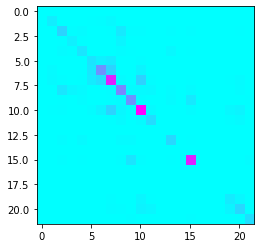

In [98]:
import numpy as np
import matplotlib.pyplot as plt


plt.imshow(trip_array, cmap='cool', interpolation='nearest')
plt.show()

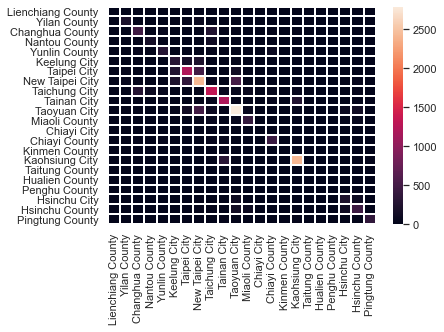

In [112]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
sns.set(font=myfont.get_family())

ax = sns.heatmap(trip_array, linewidth=0.3,xticklabels=cityName_eng_list, yticklabels=cityName_eng_list)
                 

plt.show()


figure = ax.get_figure()    
figure.savefig('svm_conf.png', dpi=400,bbox_inches = 'tight')